#멜론 TOP30 노래 정보 시각화

## 1. 패키지 설치 및 임포트

In [ ]:
# Google Drive 마운트
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# 필요한 라이브러리 설치
!pip install koreanize-matplotlib konlpy nltk
!apt-get update -qq
!apt-get install -y openjdk-11-jdk

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 52.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 70.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 493.8/493.8 kB 31.3 MB/s eta 0:00:00
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  fonts-dejavu-core fonts-dejavu-extra libatk-wrapper-java libatk-wrapper-java-jni libfontenc1
  libice-dev libsm-dev libxkbfile1 libxt-dev libxtst6 libxxf86dga1 openjdk-11-jre x11-utils
Suggested packages:
  libice-doc libsm-doc libxt-doc openjdk-11-demo openjdk-11-source visualvm mesa-utils
The following NEW packages will be installed:
  fonts-dejavu-core fonts-dejavu-extra libatk-wrapper-java libatk-wrapper-java-jni l

In [ ]:
# 라이브러리 불러오기
import pandas as pd
from collections import Counter
import re
from konlpy.tag import Okt
from nltk.stem import PorterStemmer
import matplotlib.pyplot as plt
import koreanize_matplotlib

## 2. 데이터 전처리

In [ ]:
# 형태소 분석기 및 어간 추출기 초기화
okt = Okt()
ps = PorterStemmer()

In [ ]:
# 불용어 리스트
stopwords = [
    '으로', '너를', '나를', '내가', '네가', '나의', '너의', '니가', '너가', '내가',
    '나는', '너는', '내게', '네게', '나만', '너만', '우리', '저희', '그대', '그녀',
    '그들', '그의', '너희', '나의', '너희들', '우리들', '너도', '나도', '그것', '이것',
    '저것', '어디', '뭐라', '어떻게', '때문에', '그리고', '그래서', '그러니까', '하지만',
    '보다', '듯이', '마저', '조차', '마다', '그냥', '정말', '너무', '뭐가', '아니',
    '하면', '다시', '없어', '이렇게', '없는', '이제', '이젠', '지금', '모두', '너와',
    '모든', '않아', '싶어', '보고', '있어', '자꾸', '같아', '다른', '말', '못', '맘', '눈', '그',
    '하다', '있다', '보다', '없다', '모르다', '사람', '않다', '그렇다', '되다', '싶다',
    '알다', '같다', '가다', '잊다', '오다', '생각', '오늘', '아니다', '마음', '가슴',
    '기다리다', '시간', '돼다', '세상', '나르다', '내다', '어떻다', '나다', '하나', '떠나다', '자다',
    '하루', '기억', '주다', '이렇다', '아무', '만나다', '버리다', '들다',
    '혼자', '차다', '아직', '보내다', '모습', '순간', '매일', '노래', '살다', '남자', '거야', '원하다',
    '함께', '추억', '우린', '여자', '많다', '그때', '바람', '많이', '하늘',
    'the', 'you', 'your', 'our', 'they', 'she', 'are', 'was', 'were', 'been',
    'being', 'have', 'has', 'had', 'does', 'did', 'for', 'with', 'about', 'from',
    'into', 'through', 'over', 'under', 'like', 'down', 'out', 'only', 'and',
    'that', 'this', 'these', 'those', 'because', 'there', 'here', 'what', 'when',
    'where', 'how', 'why', 'just', 'even', 'also', 'baby', 'yeah', 'know',
    'don', 'boy', 'girl', 'hey', 'tell', 'let', 'wanna', 'can', 'babi', 'thi',
    'want', 'hot', 'boom', 'come', 'say',
    '불다', 'get', '싫다', 'now', '찾다', 'woo', '예쁘다', '말다',
    '없이', '걸다', '믿다', '쉬다', '돌아오다', '한번', 'one',
    '지우다', '말고', '멈추다', '바라보다', '남다', '보이다', '그렇게', '해도',
    'put', 'knock', '떠나가다', '처음', '때문', 'danc', 'back', 'look',
    'make', '마지막', 'but', '조금', 'ooh', '잡다', '듣다',
    '누구', '놓다', '나오다', '위해', '제발', '머리', '만들다',
    '영원하다', 'day', '서로', 'got', '변하다', '항상',
    'time', '나나', 'huh', '목소리', '걷다', '해주다',
    '여기', '얘기', 'night', 'all', '느끼다', '안다',
    '언제나', '부르다', 'need', '혹시'
]

# 동의어 처리 (같은 의미의 단어를 통합)
synonym_dict = {
    '사랑': '사랑', '사랑이': '사랑', '사랑해': '사랑',  # '사랑' 관련 단어를 하나로 통합
    'love': '사랑',  # 영어 'love'도 '사랑'으로 통합
    '슬픈': '슬프다', '슬픔': '슬프다',  # '슬프다' 관련 단어를 통합
    # 필요에 따라 추가 가능
}

# 단어 정규화 함수 (어간 추출 및 정규화)
def normalize_word(word):
    # 한국어 단어 처리: 형태소 분석 및 어간 추출
    if re.fullmatch(r'[ㄱ-ㅎ가-힣]+', word):
        stems = okt.morphs(word, stem=True)
        return stems[0] if stems else word
    # 영어 단어 처리: 어간 추출
    elif re.fullmatch(r'[a-zA-Z]+', word):
        return ps.stem(word)
    return word

# 불용어 제거 및 정규화 함수
def process_words(words):
    filtered_words = []
    for word in words:
        # 동의어 처리
        word = synonym_dict.get(word, word)
        # 정규화
        normalized = normalize_word(word)
        # 불용어에 포함된 단어 제외
        if normalized in stopwords:
            continue
        # 영어 단어 2글자 이하 제외
        if re.fullmatch(r'[a-zA-Z]+', normalized) and len(normalized) <= 2:
            continue
        filtered_words.append(normalized)
    return filtered_words

# 최종 1글자 단어 필터링 함수
def final_filter(words):
    return [word for word in words if len(word) > 1]

## 3. 2003~2023년 시각화

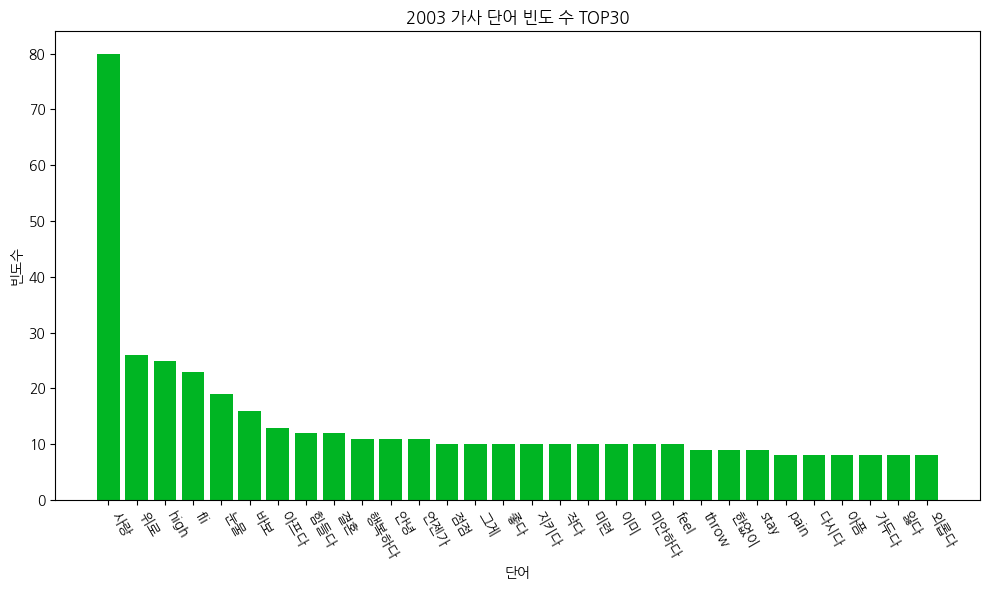

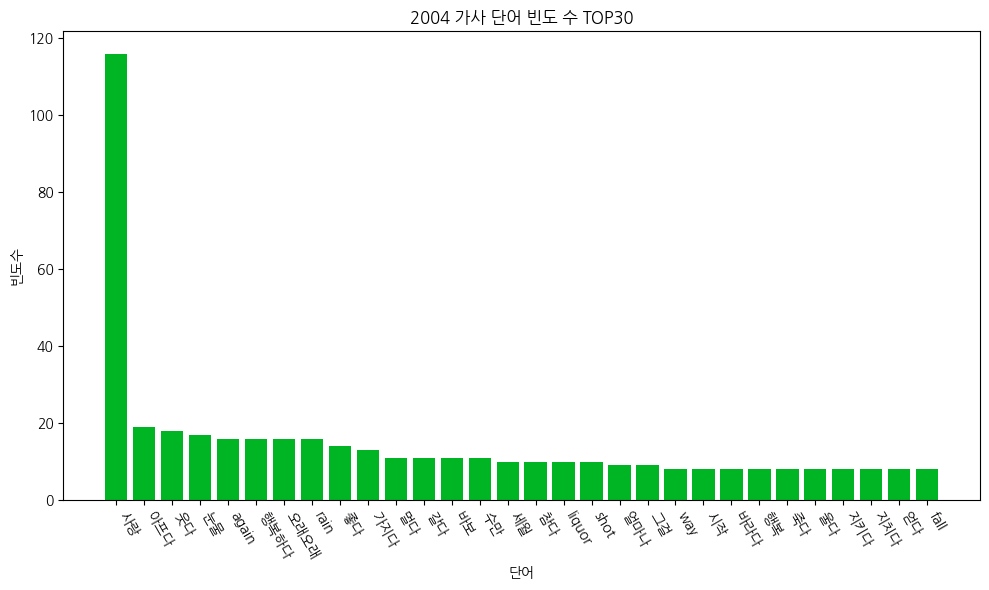

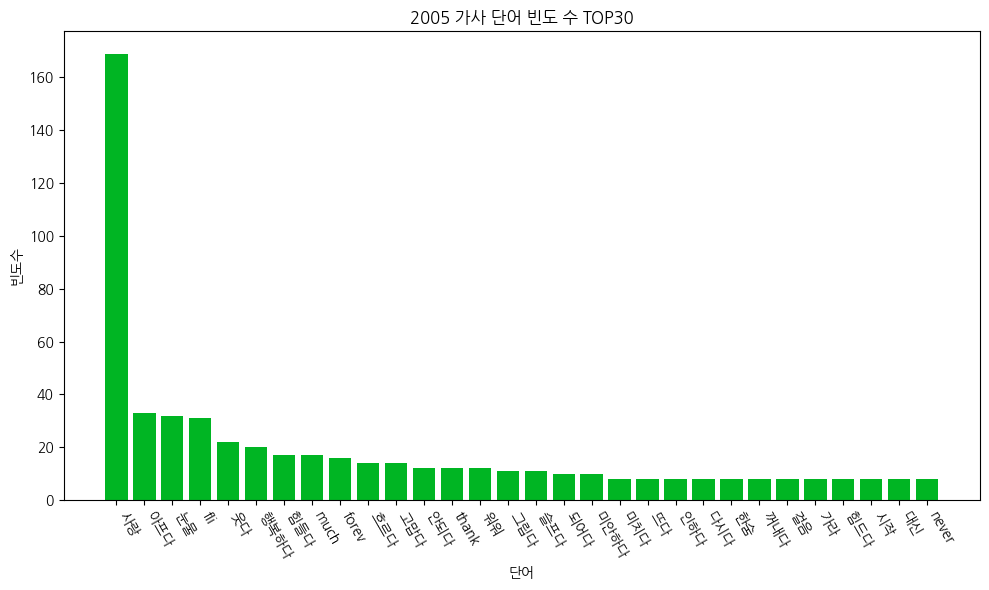

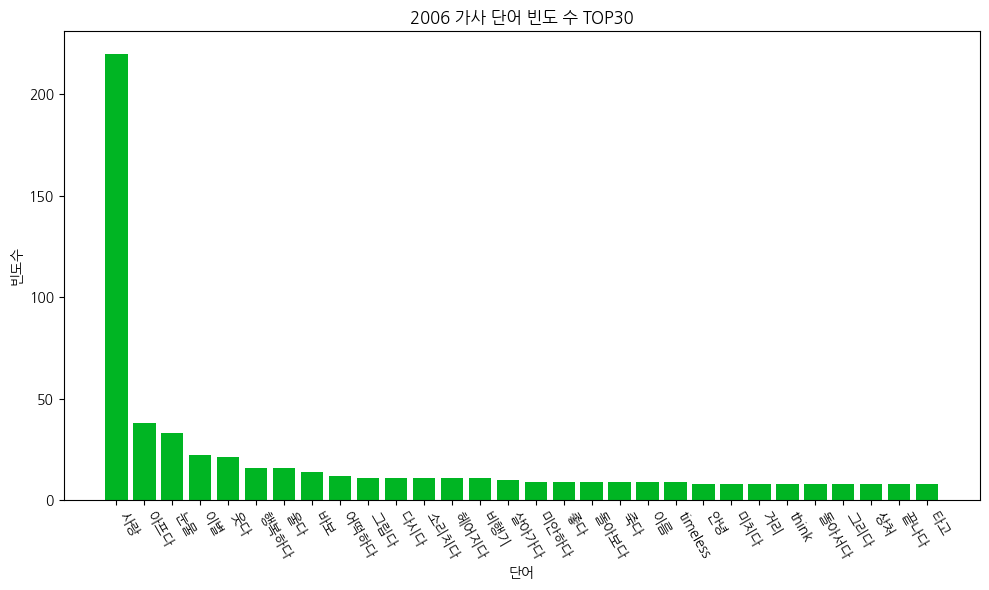

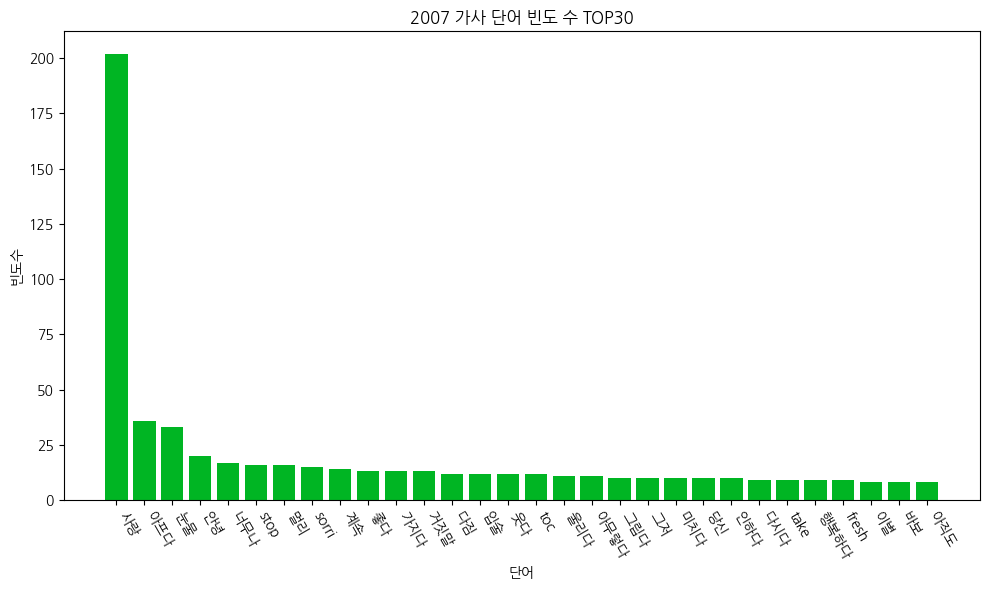

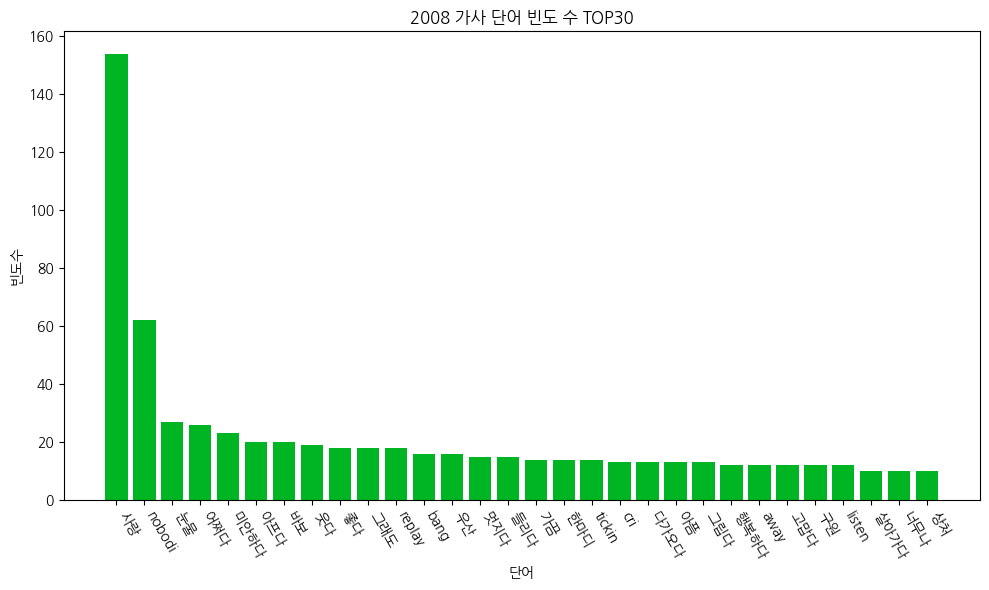

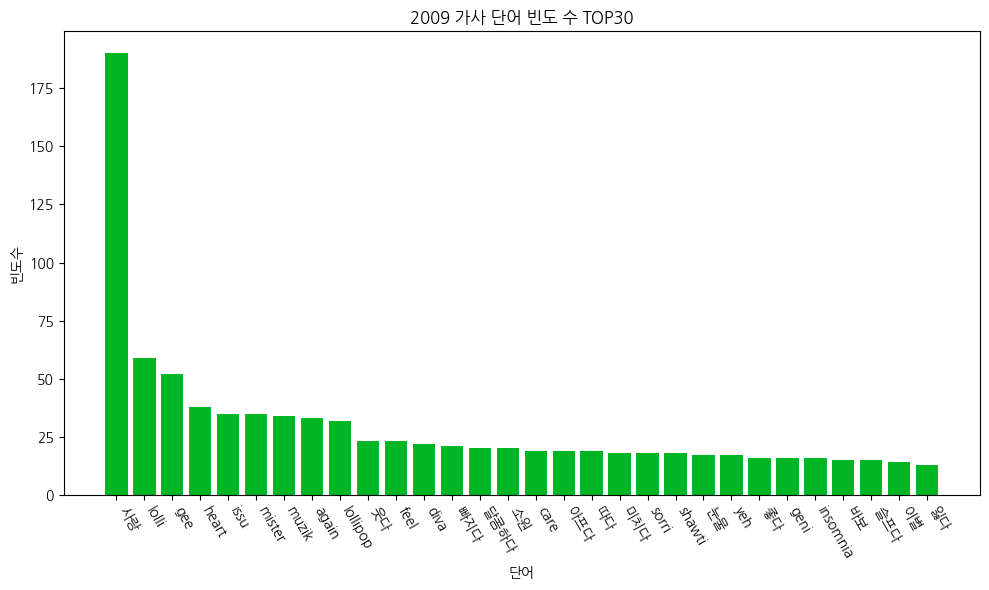

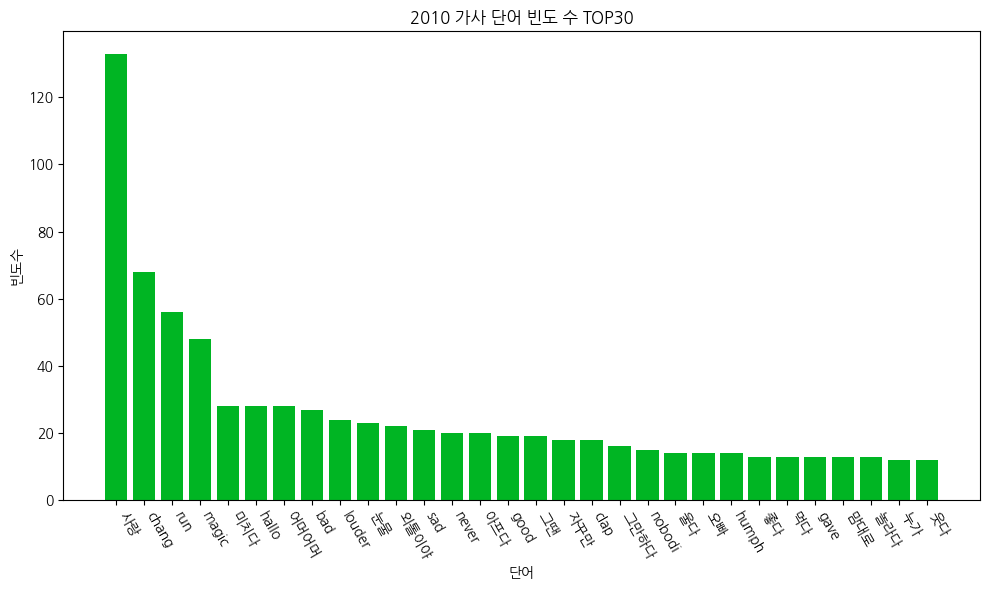

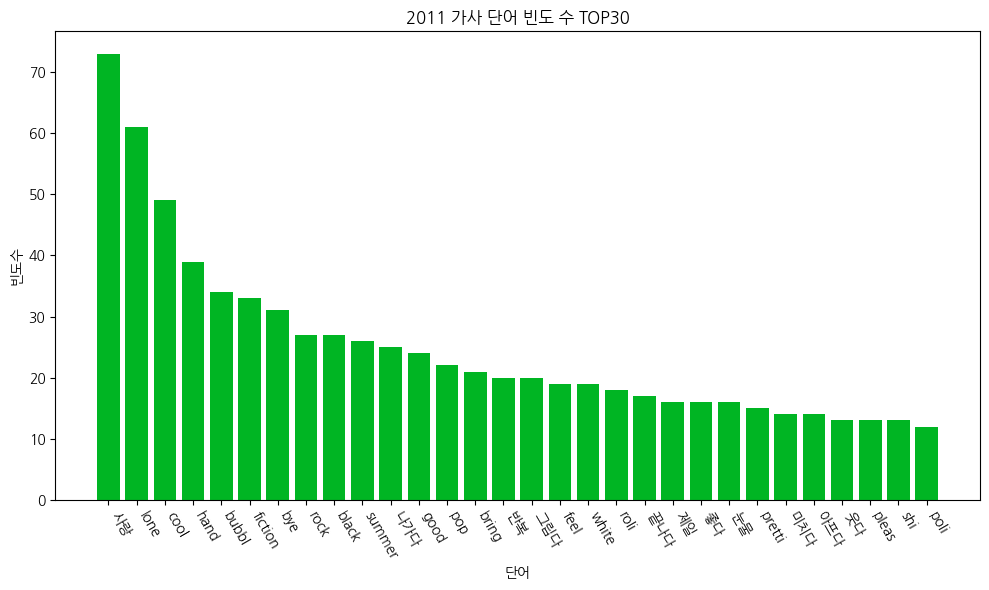

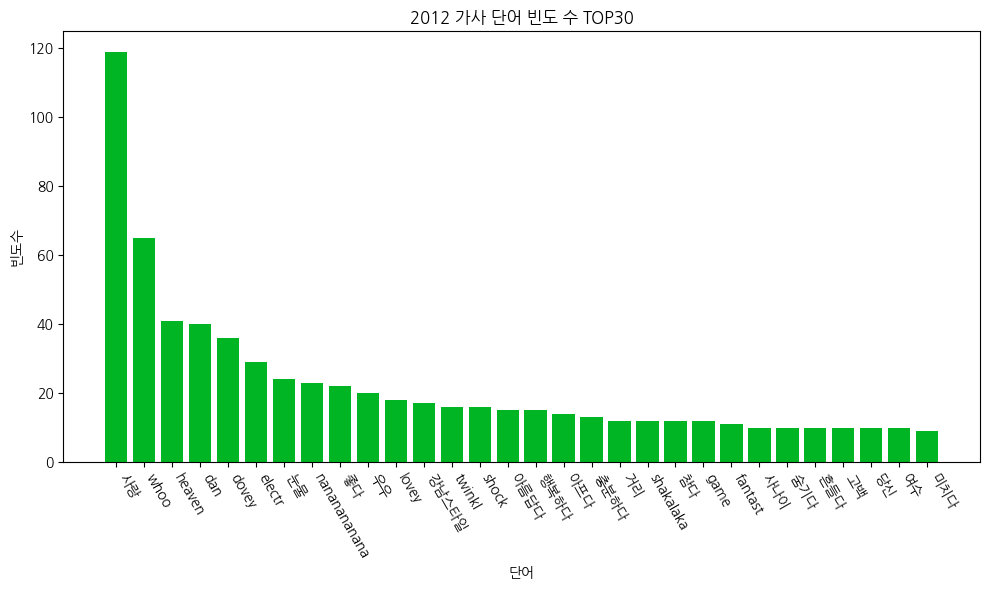

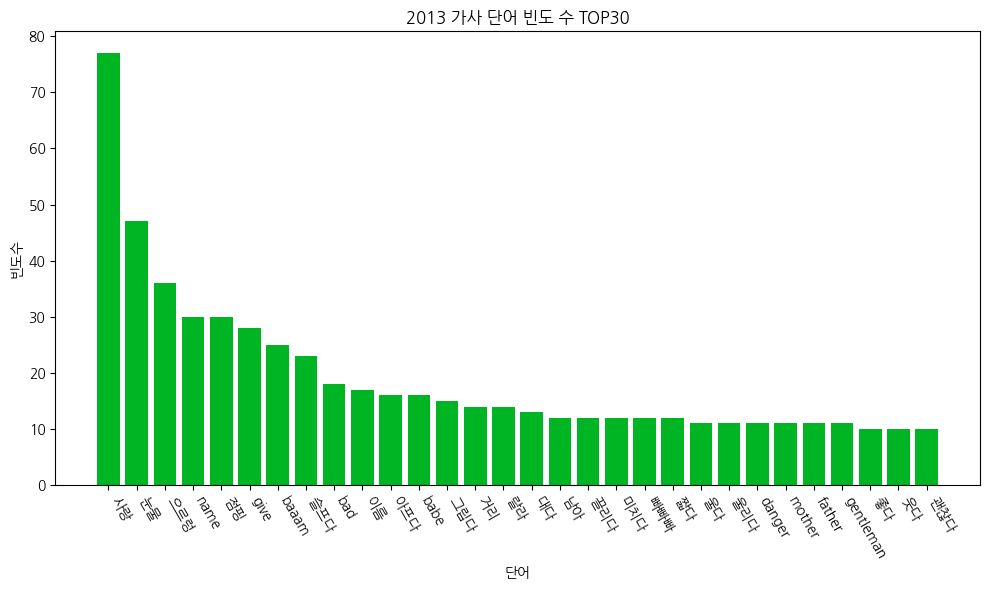

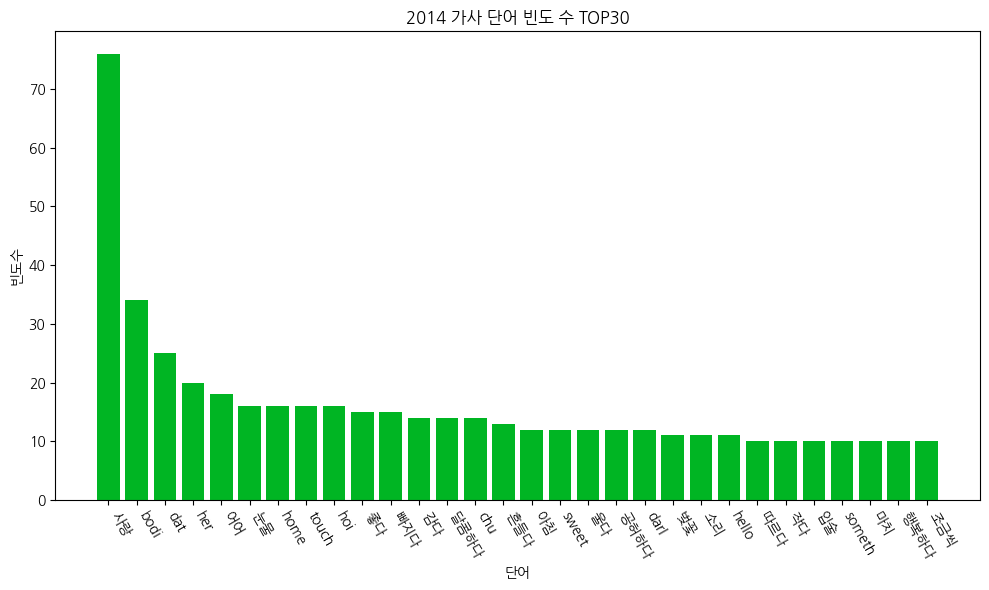

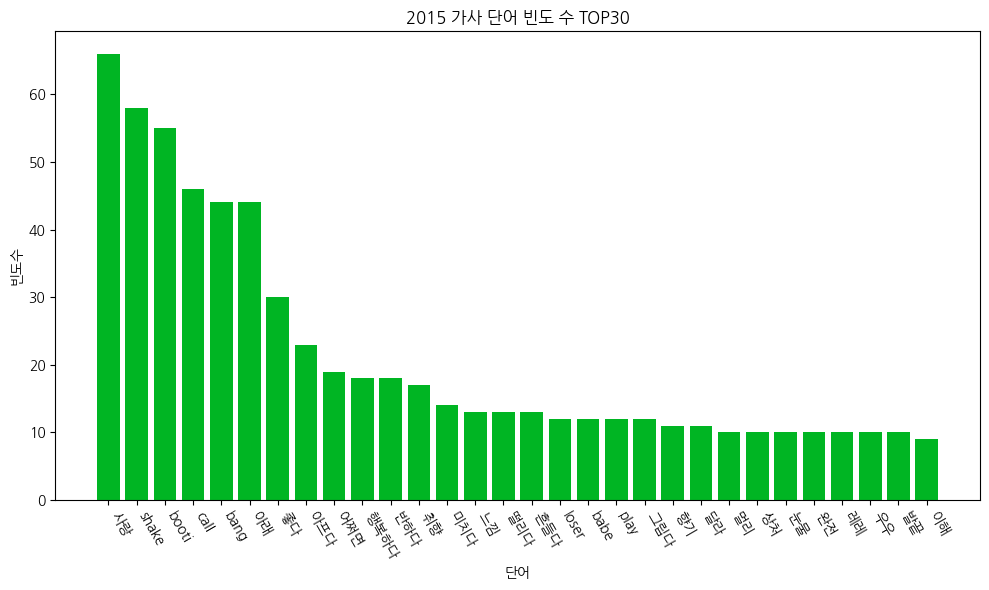

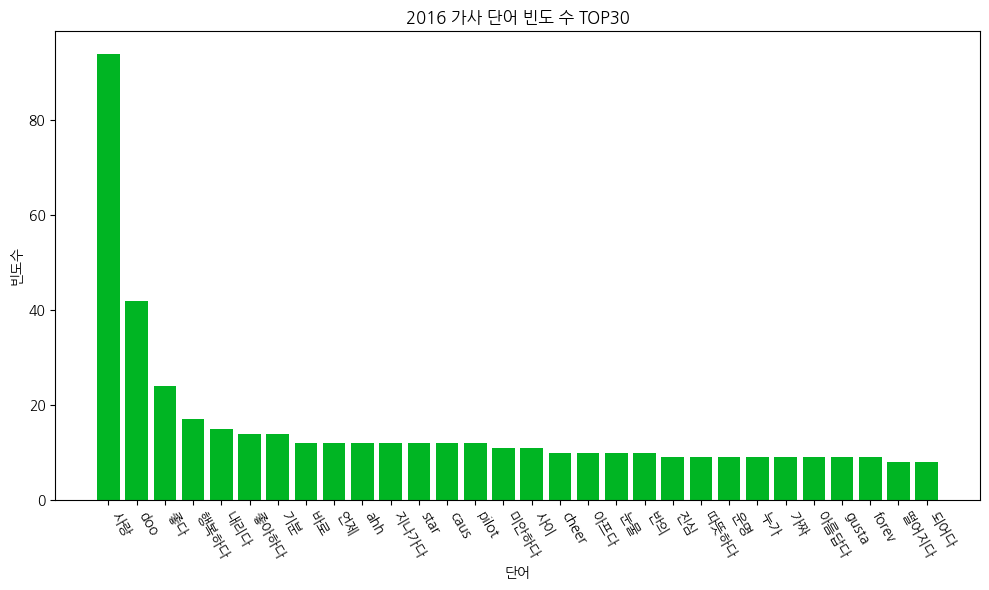

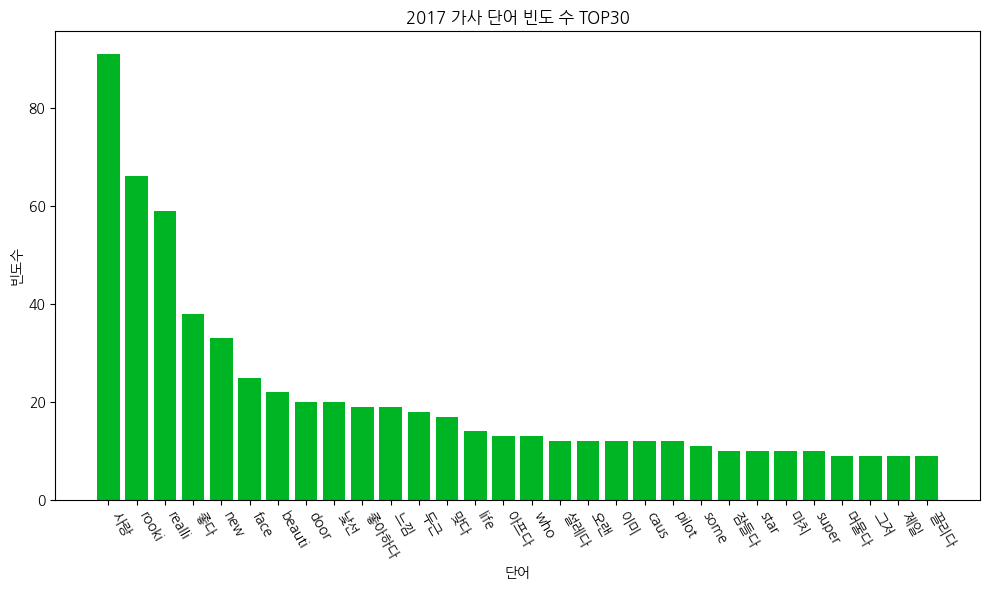

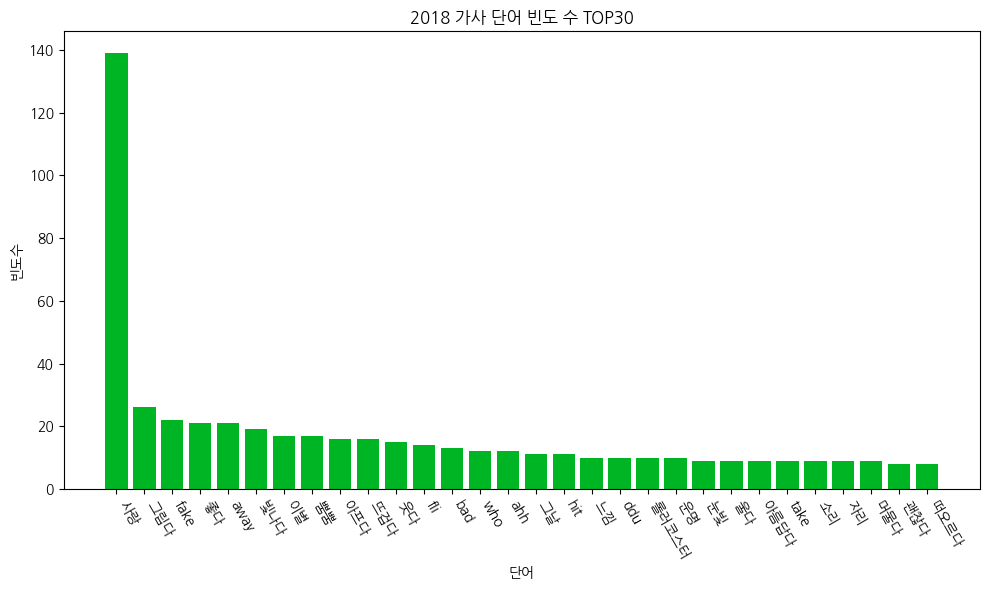

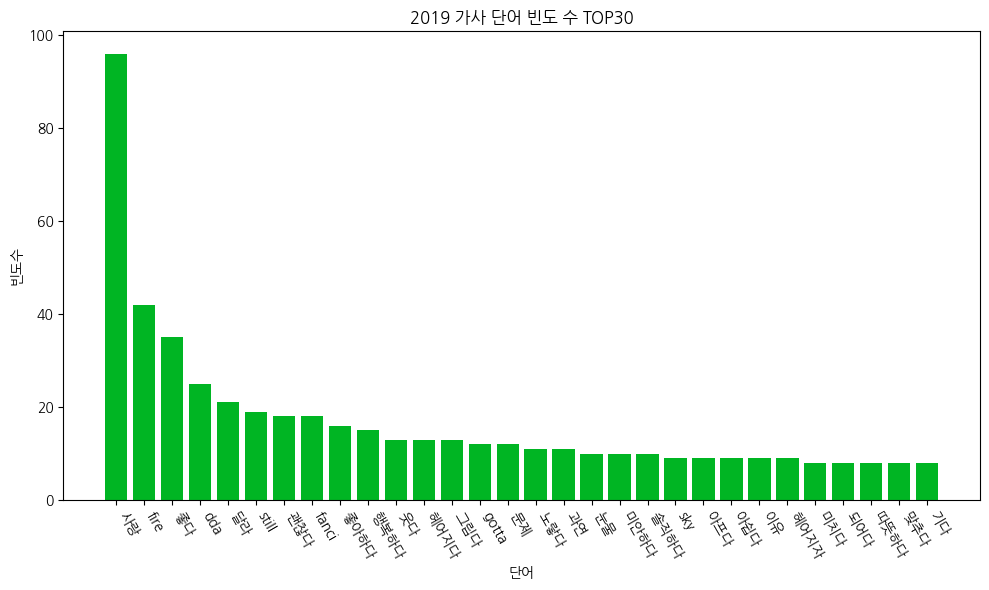

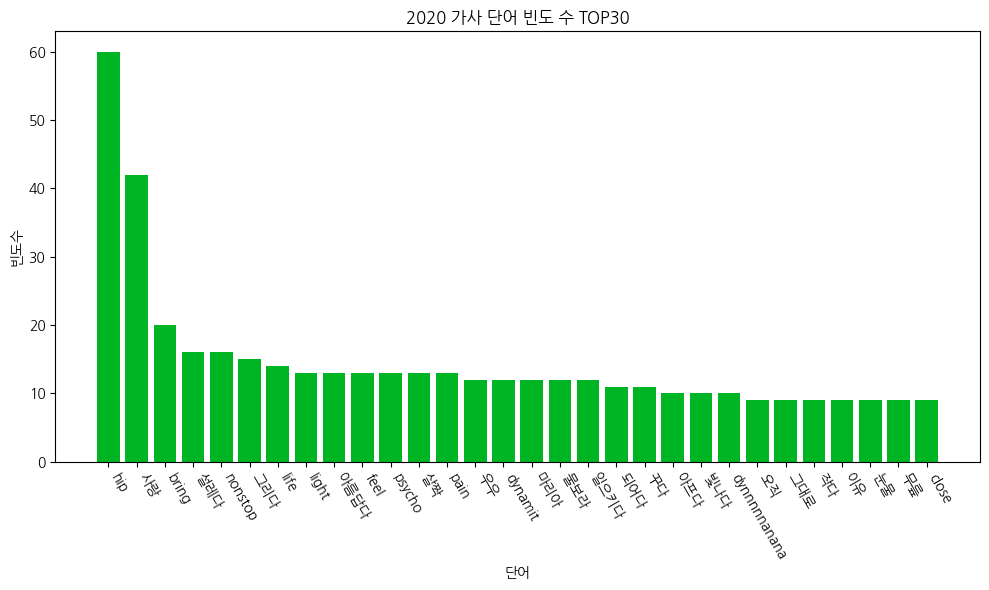

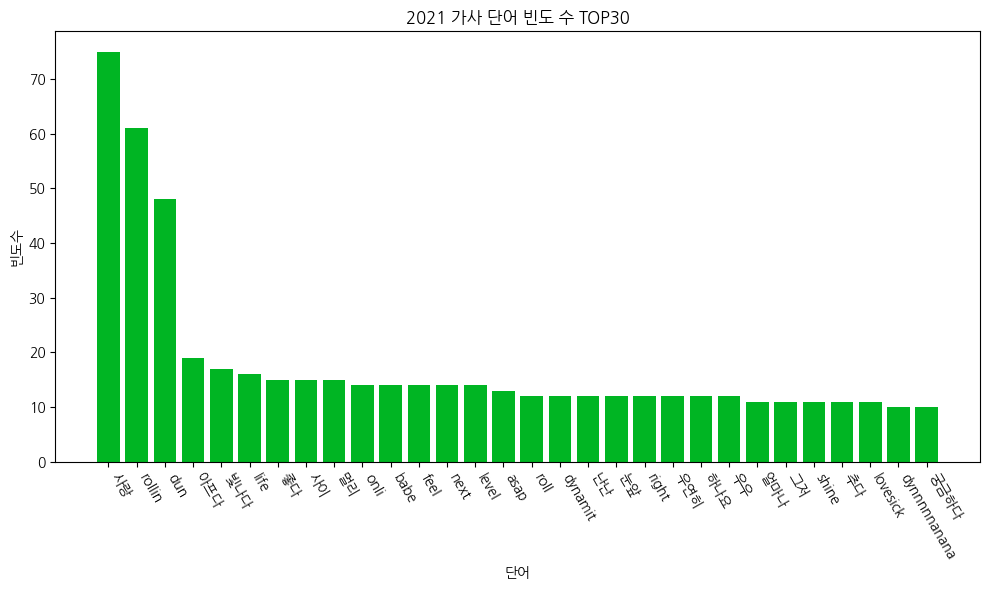

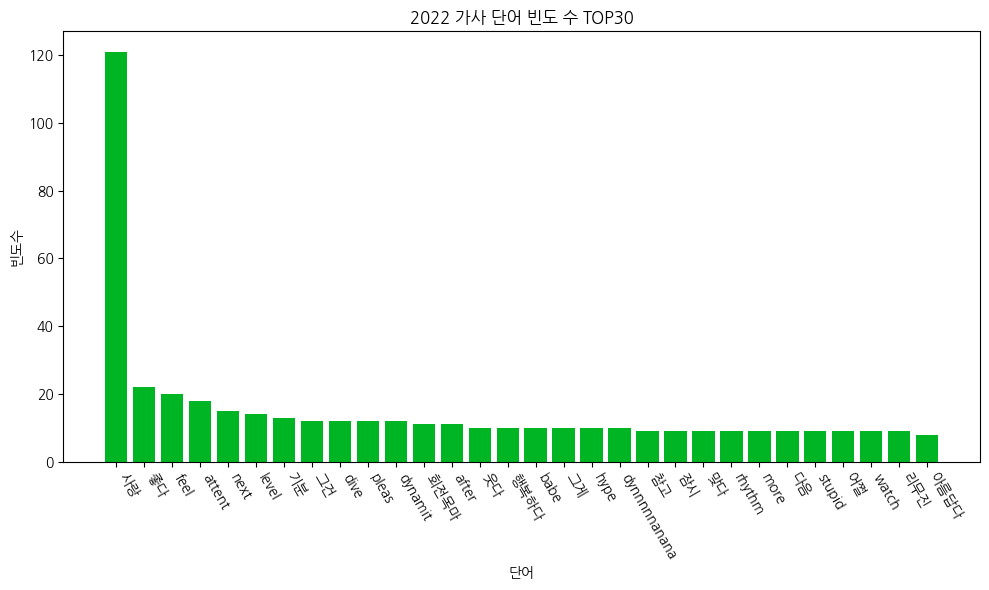

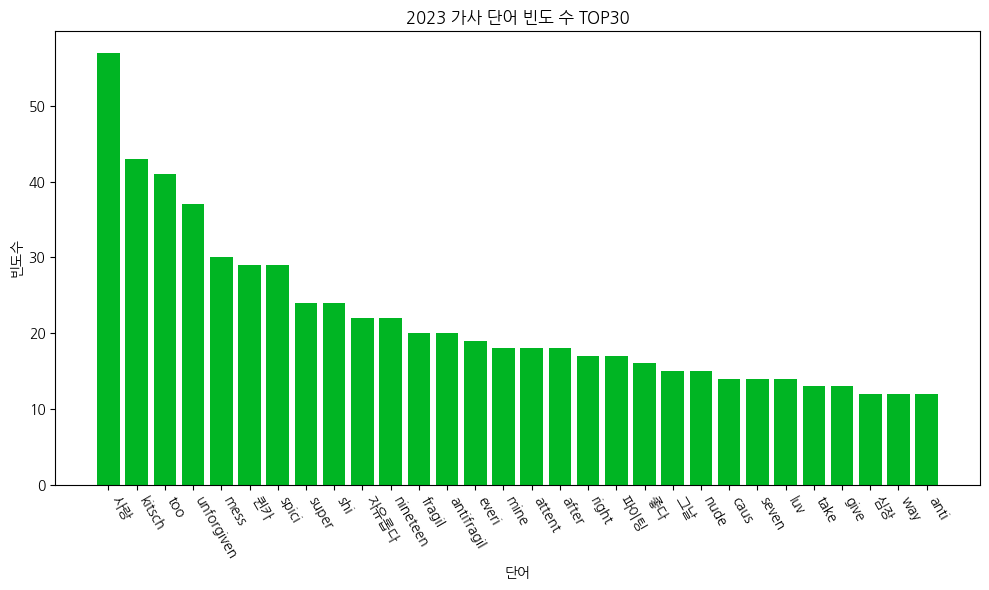

In [ ]:
import pandas as pd
import re
from collections import Counter
import matplotlib.pyplot as plt

# 연도별 데이터 분석 및 시각화 함수
def analyze_lyrics(year):
    # 파일 경로 설정
    file_path = f'/content/drive/MyDrive/DS/최종 프로젝트/멜론차트/멜론{year}년 TOP30_20241104.csv'

    # 데이터 불러오기
    df = pd.read_csv(file_path)

    # 가사 데이터를 하나의 문자열로 병합 (결측값 처리)
    all_lyrics = ' '.join(df['가사'].dropna().astype(str)).lower()

    # 단어 추출
    words = re.findall(r'\b\w+\b', all_lyrics)

    # 불용어 제거 및 정규화 적용
    words = process_words(words)

    # 최종 필터링 적용
    words = final_filter(words)

    # 단어 빈도 계산
    word_freq = Counter(words)

    # 상위 30개 단어 추출
    top_words = [word for word, freq in word_freq.most_common(30)]
    top_freqs = [freq for word, freq in word_freq.most_common(30)]

    # 막대그래프 시각화
    plt.figure(figsize=(10, 6))
    plt.bar(top_words, top_freqs, color='#00b523')
    plt.xlabel('단어')
    plt.ylabel('빈도수')
    plt.xticks(rotation=-60, ha='left')
    plt.title(f'{year} 가사 단어 빈도 수 TOP30')
    plt.tight_layout()
    plt.show()

# 2003년부터 2023년까지 반복 실행
for year in range(2003, 2024):
    analyze_lyrics(year)

## 4. 2003~2023년 통합 시각화

In [ ]:
# 데이터 불러오기
df = pd.read_csv('/content/drive/MyDrive/DS/최종 프로젝트/멜론차트/통합_멜론차트_2003-2023.csv')
all_lyrics = ' '.join(df['가사'].astype(str))

In [ ]:
# 단어 추출
words = re.findall(r'\b\w+\b', all_lyrics.lower())

# 불용어 제거 및 정규화 적용
words = process_words(words)

# 최종 필터링 적용
words = final_filter(words)

# 단어 빈도 계산
word_freq = Counter(words)

# 상위 30개 단어 추출
top_words = [word for word, freq in word_freq.most_common(30)]
top_freqs = [freq for word, freq in word_freq.most_common(30)]

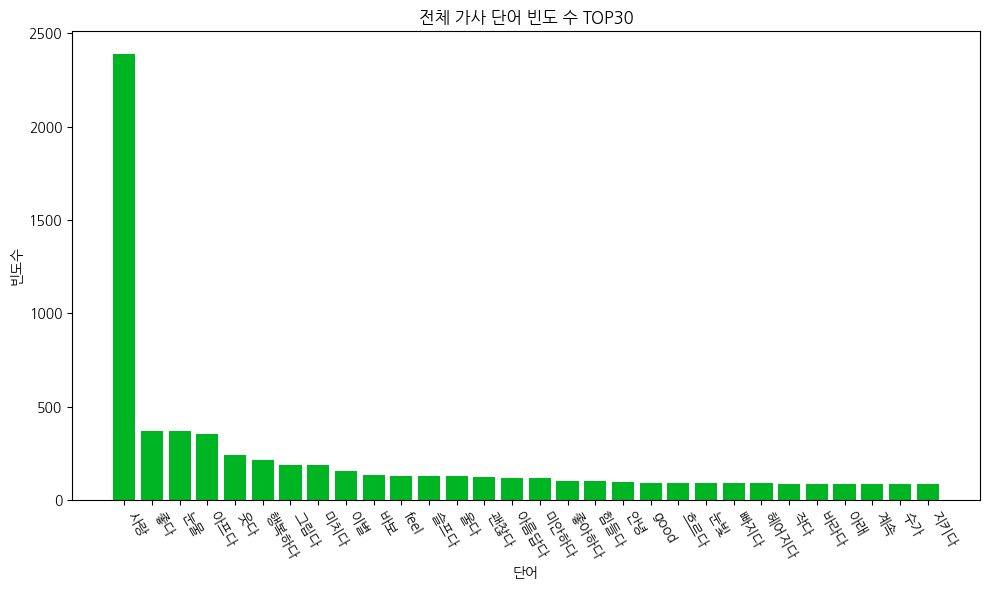

TOP 30 단어 및 빈도:
사랑: 2390
좋다: 371
눈물: 370
아프다: 356
웃다: 241
행복하다: 217
그립다: 190
미치다: 187
이별: 157
바보: 134
feel: 131
슬프다: 129
울다: 127
괜찮다: 122
아름답다: 121
미안하다: 120
좋아하다: 102
힘들다: 100
안녕: 95
good: 92
흐르다: 90
눈빛: 90
빠지다: 90
헤어지다: 89
작다: 88
바라다: 88
아래: 87
계속: 87
수가: 86
지키다: 86


In [ ]:
# 시각화
plt.figure(figsize=(10, 6))
plt.bar(top_words, top_freqs, color='#00b523')
plt.xlabel('단어')
plt.ylabel('빈도수')
plt.title('전체 가사 단어 빈도 수 TOP30')
plt.xticks(rotation=-60, ha='left')
plt.tight_layout()
plt.show()

# 상위 30위 단어와 빈도 출력
print("TOP 30 단어 및 빈도:")
for word, freq in zip(top_words, top_freqs):
    print(f"{word}: {freq}")